# Pacotes e dados

## Pacotes

In [0]:
# Install Kaggle API for download competition data
!pip3 install -q kaggle

In [210]:
!pip install pydicom

In [0]:
# Importar os pacotes
import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile
import pydicom as dicom
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import backend as K 
K.set_image_data_format('channels_last')

## Dados

### Kaggle rsna

In [0]:
kjson = pd.read_json('kaggle.json',typ='series')

In [0]:
# enter your Kaggle credentionals here

os.environ['KAGGLE_USERNAME']= "matheuscoradini"
os.environ['KAGGLE_KEY']= kjson.key

In [214]:
!kaggle datasets download --force tawsifurrahman/covid19-radiography-database

 99% 1.14G/1.15G [00:11<00:00, 115MB/s] 
100% 1.15G/1.15G [00:11<00:00, 107MB/s]


In [215]:
!kaggle datasets download --force raddar/tuberculosis-chest-xrays-shenzhen

100% 3.51G/3.51G [01:21<00:00, 50.7MB/s]
100% 3.51G/3.51G [01:25<00:00, 44.0MB/s]


In [216]:
!unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
replace COVID-19 Radiography Database/COVID-19.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [217]:
!unzip tuberculosis-chest-xrays-shenzhen.zip

Archive:  tuberculosis-chest-xrays-shenzhen.zip
replace images/images/CHNCXR_0001_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Metadata

In [0]:
meta_tub = pd.read_csv('shenzhen_metadata.csv')

In [219]:
meta_tub.head()

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [220]:
meta_tub.findings.value_counts().head(20)

normal                                         326
bilateral PTB                                   61
Right PTB                                       45
PTB in the right upper field                    27
STB                                             19
PTB in the left upper field                     19
left PTB                                        19
Bilateral secondary PTB                         16
secondary PTB  in the right upper field         12
right secondary PTB                             10
PTB in the bilateral upper field                 8
secondary PTB  in the left upper field           8
right upper PTB                                  6
secondary PTB  in the bilateral upper field      6
PTB in the right lower field                     4
left secondary PTB                               3
PTB  in the right upper field                    3
PTB in the left lower field                      3
PTB in the bilateral upper fields                3
PTB                            

In [0]:
meta_tub.loc[meta_tub['findings'] == 'normal', 'findings'] = 1
meta_tub.loc[meta_tub['findings'] != 1, 'findings'] = 3

In [222]:
meta_tub.findings.value_counts()

3    336
1    326
Name: findings, dtype: int64

In [0]:
y_tub = meta_tub.findings

## Diretório de imagem

In [224]:
# Lista o conteúdo 
os.listdir('COVID-19 Radiography Database/')

['Viral Pneumonia',
 'NORMAL',
 'README.md.txt',
 'Viral Pneumonia.matadata.xlsx',
 'NORMAL.metadata.xlsx',
 'COVID-19.metadata.xlsx',
 'COVID-19']

In [0]:
imagens_normal = 'COVID-19 Radiography Database/NORMAL'
imagens_covid = 'COVID-19 Radiography Database/COVID-19'
imagens_pneu = 'COVID-19 Radiography Database/Viral Pneumonia'
imagens_sh = 'images/images'

In [226]:
print(len(os.listdir(imagens_normal)))

1341


In [227]:
print(len(os.listdir(imagens_covid)))

219


In [228]:
print(len(os.listdir(imagens_pneu)))

1345


In [229]:
print(len(os.listdir(imagens_sh)))

662


In [0]:
covid_image_list = os.listdir(imagens_normal)
normal_image_list = os.listdir(imagens_covid)
pneu_image_list = os.listdir(imagens_pneu)
sh_image_list = os.listdir(imagens_sh)

# Preparing features

In [0]:
paths = []
y = []

for dirname, _, filenames in os.walk('COVID-19 Radiography Database/Viral Pneumonia'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(0)
            
for dirname, _, filenames in os.walk('COVID-19 Radiography Database/NORMAL'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(1)   

for dirname, _, filenames in os.walk('COVID-19 Radiography Database/COVID-19'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(2)

for dirname, _, filenames in os.walk(imagens_sh):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
y_tub = list(y_tub)
y.extend(y_tub)

In [232]:
len(paths)

3567

In [233]:
len(y)

3567

In [0]:
X = []
for i in paths:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (128, 128))

    X.append(image)

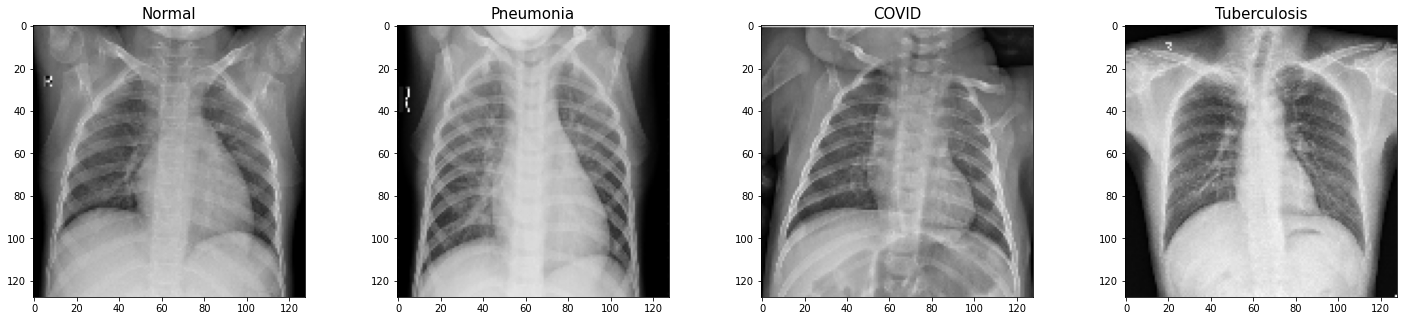

In [235]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols = 4,nrows = 1, figsize = (25,5))
ax1.imshow(X[1500],cmap='gray')
ax2.imshow(X[0],cmap='gray')
ax3.imshow(X[2900],cmap='gray')
ax4.imshow(X[-1],cmap='gray')

ax1.set_title('Normal',fontsize=15)
ax2.set_title('Pneumonia',fontsize=15)
ax3.set_title('COVID',fontsize=15)
ax4.set_title('Tuberculosis',fontsize=15)

plt.show()

In [0]:
X = np.array(X)/255
y = np.array(y)

In [0]:
X = X.reshape(-1,128,128,1)

In [238]:
X.shape

(3567, 128, 128, 1)

# Train Test Split

In [0]:
Xtrain, Xval, ytrain, yval  = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [0]:
ycat_val = to_categorical(yval,4)
ycat_train = to_categorical(ytrain,4)

# Model

In [0]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(128,128,1), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(128,128,1), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(128,128,1), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(126))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [242]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)       

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=15)

In [0]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [245]:
cw = {0: 1, 1: 1, 2:3, 3:1.5}
BS = 16
results = model.fit_generator(image_gen.flow(Xtrain, ycat_train, batch_size=BS),
                              steps_per_epoch=len(Xtrain)/BS, epochs=100,
                              validation_data=(Xval,ycat_val), callbacks = [early_stop], class_weight=cw)

Epoch 1/100
150/149 [==============================] - 6s 42ms/step - loss: 1.3722 - accuracy: 0.4902 - val_loss: 0.9056 - val_accuracy: 0.5620
Epoch 2/100
150/149 [==============================] - 6s 39ms/step - loss: 0.9936 - accuracy: 0.6367 - val_loss: 0.6347 - val_accuracy: 0.7224
Epoch 3/100
150/149 [==============================] - 6s 38ms/step - loss: 0.8906 - accuracy: 0.6815 - val_loss: 0.5880 - val_accuracy: 0.7589
Epoch 4/100
150/149 [==============================] - 6s 38ms/step - loss: 0.7949 - accuracy: 0.7187 - val_loss: 0.4833 - val_accuracy: 0.7903
Epoch 5/100
150/149 [==============================] - 6s 38ms/step - loss: 0.7190 - accuracy: 0.7468 - val_loss: 0.4254 - val_accuracy: 0.8022
Epoch 6/100
150/149 [==============================] - 6s 38ms/step - loss: 0.6445 - accuracy: 0.7698 - val_loss: 0.4248 - val_accuracy: 0.8149
Epoch 7/100
150/149 [==============================] - 6s 38ms/step - loss: 0.6329 - accuracy: 0.7664 - val_loss: 0.3861 - val_accuracy:

In [246]:
model.metrics_names

['loss', 'accuracy']

In [0]:
losses = pd.DataFrame(model.history.history)

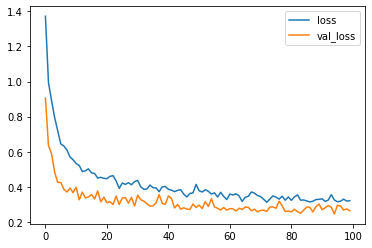

In [248]:
losses[['loss','val_loss']].plot()
plt.show()

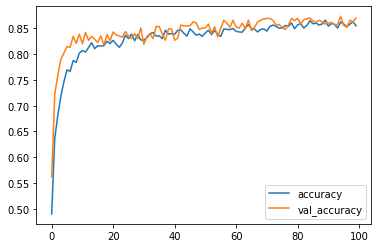

In [249]:
losses[['accuracy','val_accuracy']].plot()
plt.show()

In [0]:
pred = model.predict_classes(Xval)

In [251]:
# 0: Pneumonia
# 1: Normal
# 2: COVID-19
# 3: Tuberculosis

from sklearn.metrics import classification_report
print(classification_report(yval, pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       463
           1       0.91      0.81      0.86       529
           2       0.96      0.89      0.92        73
           3       0.51      0.88      0.65       113

    accuracy                           0.87      1178
   macro avg       0.84      0.88      0.84      1178
weighted avg       0.90      0.87      0.88      1178



In [252]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yval, pred)

array([[434,  26,   3,   0],
       [  8, 426,   0,  95],
       [  4,   2,  65,   2],
       [  0,  13,   0, 100]])

In [253]:
y.shape

(3567,)